In [4]:
import jax
from cft import *
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
import optax

from functools import partial


In [5]:
def boots(beta,c, params, opt_fn, opt_state, steps=100):
    """ finds deltas

        Params:
        beta - random point for beta
        c - central charge
        deltas - intitalised deltas
        opt_fn - optimization function e.g. Adam
        opt_state - initial state

        Returns:
        losses, deltas, state

    """
    @jit
    def loss_function(params):
        identy = vmap(reduced_partition_function_spinless, in_axes=(0,0,None), out_axes=0)(params, beta, c)
        transformed = vmap(reduced_partition_function_spinless, in_axes=(0,0, None), out_axes=0)(params, 1/beta, c)
        return jnp.mean((identy-transformed)**2) # mean squared loss

    losses = []
    for _ in tqdm(range(steps)):
        # loss and gradients calulated with 
        loss, grads = jax.value_and_grad(loss_function)(params) 
        updates, opt_state = opt_fn(grads, opt_state)
        params += updates
        losses.append(loss) 

    return jnp.stack(losses), params, opt_state


100%|██████████| 1000/1000 [00:03<00:00, 268.44it/s]


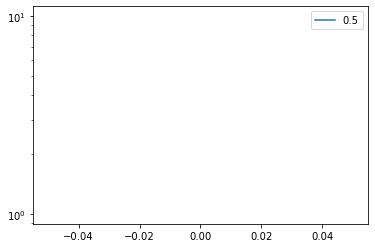

In [12]:
batch_size = 128
rng = random.PRNGKey(0)
keys = random.split(rng, 2)
beta = (random.uniform(keys[0], (batch_size,)) + 1/2 )*0.25
params = random.uniform(keys[1], (batch_size, 2, 6))*10

c = 12
step=1000

# test for different learning rates
for lr in [5e-1]:
    adam = optax.adam(learning_rate=lr)
    losses, params, _ = boots(beta, c, params, opt_fn=adam.update, opt_state=adam.init(params),steps=step)
    steps = np.linspace(1,step,step)
    plt.plot(steps,losses,label=f"{lr}")
    plt.yscale("log")
    plt.legend()

    # print(learned_deltas)

100%|██████████| 100000/100000 [04:37<00:00, 360.87it/s]


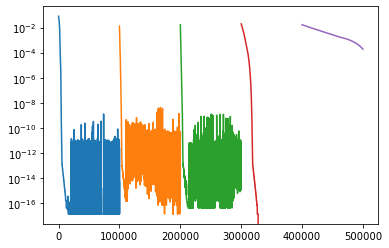

In [75]:
batch_size = 64
rng = random.PRNGKey(0)
key_n, *keys = random.split(rng, 3)
deltas = random.uniform(keys[1], (batch_size, 6))*5
step=100000
lr = 0.001
params = random.uniform(keys[1], (batch_size, 2, 6))*10

for epoch in range(5):
    key_n, *keys = random.split(key_n, 3)
    beta = (random.uniform(keys[0], (batch_size,)) + 1/2 )*0.25
    c = 1/2
    if epoch>2:
        lr = lr/10
    adam = optax.adam(learning_rate=lr)
    # if epoch > 2:
    # lr = lr/10

    losses, params, _ = boots(beta, c, params, opt_fn=adam.update, opt_state=adam.init(params),steps=step)
    steps = np.linspace(epoch*step+1,(epoch+1)*step,step)
    plt.plot(steps,losses)
    plt.yscale("log")


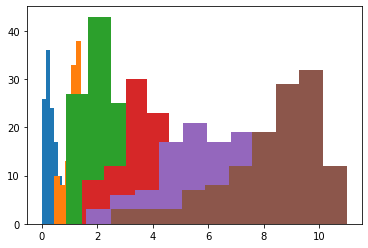

In [68]:
sorted_deltas = jnp.sort(deltas)
for i in range(6):
    counts, bins = np.histogram(sorted_deltas[:,i])
    plt.hist(bins[:-1], bins, weights=counts)



## Random Rough stuff beyond this point

In [48]:
c = 1
def loss_function(deltas,beta,c):
        identy = vmap(reduced_partition_function_spinless, in_axes=(0,0,None), out_axes=0)(deltas,beta,c)
        transformed = vmap(reduced_partition_function_spinless, in_axes=(0,0,None), out_axes=0)(deltas,1/beta,c)
        return jnp.mean((identy-transformed)**2) # mean squared loss




loss_function(deltas,beta,c)

DeviceArray(3.0548825, dtype=float32)